# Basic Environment Usage

In this example we will play around with the environment used for the experiments in 

[*Luis Pineda, Sumana Basu, Adriana Romero, Roberto Calandra, Michal Drozdzal, Active MR k-space Sampling with Reinforcement Learning". MICCAI 2020.*](https://arxiv.org/pdf/2007.10469.pdf)

In particular, we will create an instance of this environment, and evaluate the performance of two simple baselines (random and low-to-high policies).

## Initial setup

As shown in the following steps, before running this example, we need to download the fastMRI dataset, as well as saved checkpoints for the reconstruction model [(see original paper)](https://openaccess.thecvf.com/content_CVPR_2019/papers/Zhang_Reducing_Uncertainty_in_Undersampled_MRI_Reconstruction_With_Active_Acquisition_CVPR_2019_paper.pdf) used in the MICCAI paper.

**FastMRI Dataset**

For instructions on how to download the dataset, please visit https://fastmri.med.nyu.edu/. This example uses the `knee_singlecoil_train` and `knee_singlecoil_val` sets. Download the zip files and save them under the same folder, then configure the environment to locate them. This can be done by editing file `$USER_HOME/.activemri/defaults.json` and adding the folder as the value of key `"data_location"`.

**Reconstructor model**

The reconstructor checkpoint can be downloaded from xxxxxxxxx. You also need to configure the environment to locate the model, by adding the folder name under key `"saved_models_dir"` in file `$USER_HOME/.activemri/defaults.json`.

## Code

In [1]:
import os

os.chdir("..")

import imageio; 
from IPython.display import Video; 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import activemri.baselines
import activemri.envs

%matplotlib inline
mpl.rcParams['figure.facecolor'] = 'white'
font = {'size'   : 16}

mpl.rc('font', **font)

### Create the environment

The line below creates an instance of this environment that handles batches of 16 images (argument `num_parallel_episodes`, one episode per image), runs episodes for 20 acquisiton steps (`budget=20`), and uses the "Scenario30L" setting described in the paper (`extreme=False`). Note that you might need to adjust the batch size to meet your GPU memory constraints. 

You can check other configuration options for the environment in file `configs/miccai-2020-normal-acc.json`. In particular, we note that initial masks for each episode consist of the 15th lowest frequencies (on each side). Note that, since our checkpoint includes an `"options"` key, the reconstructor options in the JSON file will be overriden, and the environment emits a warning about this.


In [2]:
env = activemri.envs.MICCAI2020Env(num_parallel_episodes=16, budget=20, extreme=False, seed=1234)

print("Number of available actions:", env.action_space.n)

/private/home/lep/code/active-mri-acquisition/activemri/envs/envs.py:307: UserWarning: Checkpoint at miccai2020_reconstructor_raw_normal.pth has an 'options' key. This will override the options defined in configuration file.
  warnings.warn(msg)


Number of available actions: 368


### Starting an episode

The environment can be used just like any other [gym](https://gym.openai.com/docs/) environment. Under the hood, it will load a batch of k-space and image data from the fastMRI dataset, and then create an input tensor to the reconstruction model using the initial masks specified in the configuration file. The reconstruction computed by the model, along with any extra outputs, is returned by the environment as an observation.

As a technical detail, we mention that to process the data from the loader, the environment relies on the function specified by `config["reconstructor"]["transform"]`, in the JSON config file. This function takes the output of the fastMRI dataset, and generates a batch of inputs for the reconstruction model. For this example, the function we use is `activemri.data.transforms.raw_transform_miccai2020`. 

In [3]:
obs, metadata = env.reset()

#### Observation format

The environment returns an observation with three keys: `"reconstruction"`, `"extra_outputs"`, and `"mask"`.

In [4]:
print(obs.keys())

dict_keys(['reconstruction', 'extra_outputs', 'mask'])


Key `"reconstruction"` is the reconstruction tensor, which for the model used in this example (`activemri.models.cvpr19_reconstructor.CVPR19Reconstructor`) has shape `(batch_size, k_space_height, k_space_width, real_img)`

In [5]:
print(obs["reconstruction"].shape)

torch.Size([16, 640, 368, 2])


Key `"extra_outputs"` is a dictionary that contains additional outputs (if any) of the reconstruction model. The model in this example also returns an uncertainty map, and a learned embedding for the mask. 

In [6]:
print(obs["extra_outputs"].keys())

dict_keys(['uncertainty_map', 'mask_embedding'])


Finally, the environment also returns the current acquisition mask, with shape `(batch_size, env.action_space.n)`

In [7]:
print(obs["mask"].shape)

torch.Size([16, 368])


#### Visualizing reconstructions

We can visualize the current mask, ground truth and reconstruction (left to right below) as follows

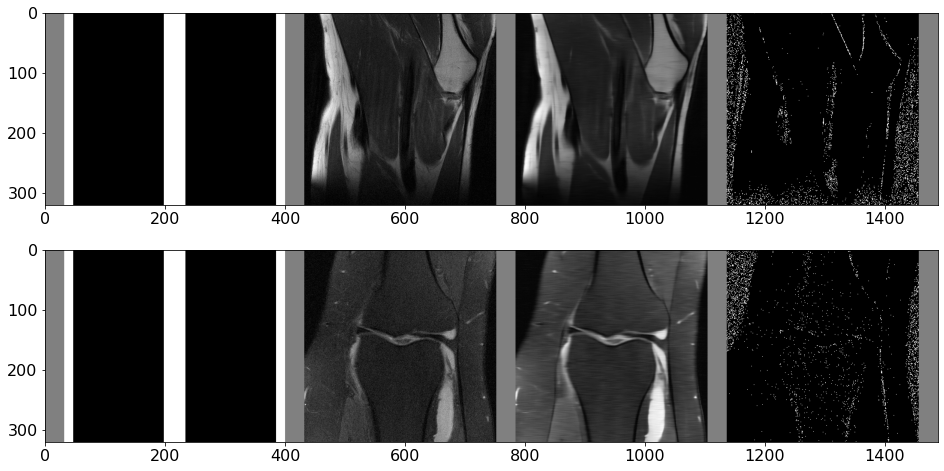

In [8]:
frame = env.render()

fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].imshow(frame[0], cmap="gray")
ax[1].imshow(frame[2], cmap="gray")
plt.show()

#### Metadata

The `reset()` method also returns metadata information about the images and reconstructions. You can refer to the documentation for a description of the metadata format.

In [9]:
print(metadata.keys())

dict_keys(['fname', 'slice_id', 'current_score'])


### Running a baseline policy

<div class="alert alert-block alert-info">
<b>Note:</b> In this example we have performed the evaluation steps manually for a few episodes to show how the environment works. However, we also provide function `activemri.baselines.evaluate()` to automate the evaluation steps shown below. </div>

Let's now evaluate policies on this environment. For example a random acquisition policy can be created as:

In [10]:
policy = activemri.baselines.RandomPolicy()

We can run an episode of this policy as shown below. Before calling `run_episode` we tell the environment to use our test split, and we also tell it to reset the data loader (`reset=True`). This is useful so that later on we can compare another policy on the same images. 

In [11]:
def run_episode(policy_):
    obs, meta = env.reset()
    frame = env.render()
    all_frames_ = [frame]
    scores_ = [meta["current_score"]]
    done = False
    while not done:
        action = policy_(obs)
        next_obs, rewards, dones, meta = env.step(action)
        done = all(dones)
        obs = next_obs
        all_frames_.append(env.render())
        scores_.append(meta["current_score"])
    return all_frames_, scores_

env.set_test(reset=True)
all_frames, scores_random = run_episode(policy)

The `step()` method works just like that of any other `gym` environment, except the outputs are batched to take advantage of the reconstructor running on GPU. It returns the next observation, an array of rewards, a list of "episode done" flags, and metadata information (e.g., current score for each of "mse", "nmse", "ssim", "psnr").

In [12]:
_, rewards, dones, meta = env.step(0)
print("Rewards: ", type(rewards), rewards.shape)
print("Dones: ", type(dones), len(dones))
print("Metadata: ", meta.keys(), meta["current_score"].keys())

Rewards:  <class 'numpy.ndarray'> (16,)
Dones:  <class 'list'> 16
Metadata:  dict_keys(['current_score']) dict_keys(['mse', 'nmse', 'ssim', 'psnr'])


<div class="alert alert-block alert-danger">
<b>Warning:</b> Note that `done` is a list of booleans, one for each element in the episode batch. Thus, the correct way to end an episode is doing `if all(done)`, otherwise you will probably get incorrect behavior. If some episodes in the batch end earlier (because all columns in the mask are already active), the environment will still continue without problems (returning 0 reward for any action on these batch elements).
</div>

### Visualizing the episode

Below we visualize the random acquisition policy using the frames collected for the batch of episodes. You can change the batch element that is being visualized below via `slice_idx` (0-15). The video shows, left to right, current mask, ground truth image, current reconstruction, and relative error per pixel. 

In [13]:
slice_idx = 4
frames = [f[slice_idx] for f in all_frames]
imageio.mimwrite("./video-1.mp4", frames, fps=1)
Video("./video-1.mp4", width=639, height=180, embed=True)

## Comparing two policies

Let's now compare the performance of the previous policy with one that chooses k-space frequencies in low to high order. The first argument (`alternate_sides`, which is set to `True`), tells the policy that we should alternate between then two sides of the mask each time step. The second argument, `centered`, indicates whether the lowest frequencies are in the center (default), or on the edges. For the MICCAI env `centered=False`.

In [14]:
policy_lowtohigh = activemri.baselines.LowestIndexPolicy(True, centered=False)

We can now run the policy on the first batch of the test set as we did above.

In [15]:
env.set_test(reset=True)
_, scores_lowtohigh = run_episode(policy_lowtohigh)

The performance of the policy can be captured by the history of reconstruction scores, obtained from the `metadata["current_score"]` dictionary returned by `env.step()`. Below we show how to plot the average SSIM over the batch for each policy, at each time step.

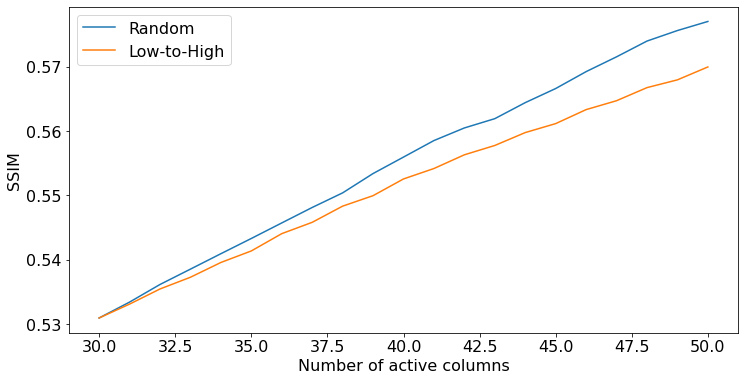

In [16]:
ssim_random = np.stack([score_t["ssim"] for score_t in scores_random])  # shape (budget, batch_size)
ssim_lowtohigh = np.stack([score_t["ssim"] for score_t in scores_lowtohigh])

length = ssim_random.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(30 + np.arange(length), ssim_random.mean(axis=1))
plt.plot(30 + np.arange(length), ssim_lowtohigh.mean(axis=1))
plt.xlabel("Number of active columns")
plt.ylabel("SSIM")
plt.legend(["Random", "Low-to-High"])
plt.show()

In this small example, the random policy performs slightly better than the low to high frequency order policy, and the gap increases as more k-space columns are aquired. 

Finally, we can repeat the above for other metrics, for example, MSE.

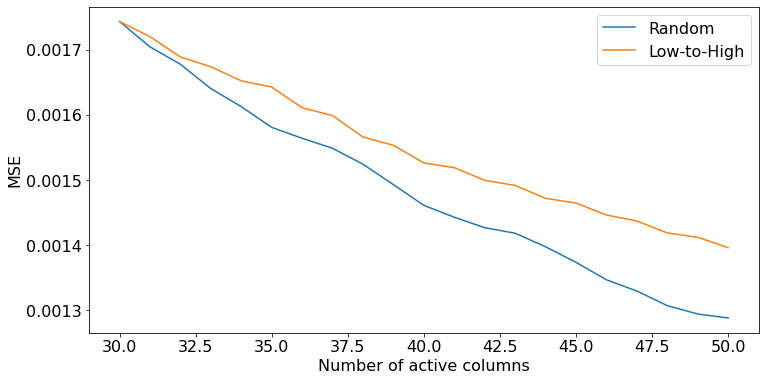

In [17]:
mse_random = np.stack([score_t["mse"] for score_t in scores_random])  # shape (budget, batch_size)
mse_lowtohigh = np.stack([score_t["mse"] for score_t in scores_lowtohigh])

length = mse_random.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(30 + np.arange(length), mse_random.mean(axis=1))
plt.plot(30 + np.arange(length), mse_lowtohigh.mean(axis=1))
plt.xlabel("Number of active columns")
plt.ylabel("MSE")
plt.legend(["Random", "Low-to-High"])
plt.show()